In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.datasets import load_boston
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model
from scipy import stats
import numpy as np


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    # def __init__(self, *args, **kwargs):
    #     if not "fit_intercept" in kwargs:
    #         kwargs['fit_intercept'] = False
    #     super(LinearRegression, self).__init__(*args, **kwargs)

    def __init__(self):
        super(LinearRegression, self).__init__(fit_intercept=False)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(
                np.diagonal(
                    sse * np.linalg.inv(
                        np.dot(X.T, X)
                    )
                )
            )
        ])

        self.X = X
        self.y = y
        self.se = se
        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

    def summary(self):
        columns = ['Estimate', 'Std. Error', 't statistic', 'P value']
        index = self.X.columns
        data = np.array([
            self.coef_,
            self.se[0],
            self.t[0],
            self.p[0]
        ]).T
        
        return pd.DataFrame(data=data, index=index, columns=columns)

In [2]:
# load data
boston = load_boston()
boston_X = boston['data']
boston_y = boston['target']

# transform into dataframe
boston_X_df = pd.DataFrame(data=boston_X, columns=boston.feature_names)

# add variable for intercept
boston_X_df['intercept'] = 1

In [3]:
boston_mlr_sm = sm.OLS(boston_y, boston_X_df.loc[:, ['LSTAT', 'AGE', 'intercept']]).fit()

print(boston_mlr_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           2.98e-88
Time:                        13:27:03   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
LSTAT         -1.0321      0.048    -21.416      0.0

In [4]:
boston_mlr_all_sm = sm.OLS(boston_y, boston_X_df).fit()

print(boston_mlr_all_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 22 Apr 2022   Prob (F-statistic):          6.72e-135
Time:                        13:27:03   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.1080      0.033     -3.287      0.0

In [5]:
n = len(boston_X_df)
p = len(boston_X_df.columns)
RSS = (boston_mlr_all_sm.resid**2).sum()
RSE = np.sqrt(RSS / (n - p - 1))
print(RSE)

4.750128002982112


In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([
    variance_inflation_factor(boston_X_df.values, i)
    for i in range(boston_X_df.shape[1])
], index=boston_X_df.columns)

CRIM           1.792192
ZN             2.298758
INDUS          3.991596
CHAS           1.073995
NOX            4.393720
RM             1.933744
AGE            3.100826
DIS            3.955945
RAD            7.484496
TAX            9.008554
PTRATIO        1.799084
B              1.348521
LSTAT          2.941491
intercept    585.265238
dtype: float64

In [7]:
from statsmodels.tools.eval_measures import rmse
RMSE = rmse(boston_y, boston_mlr_all_sm.fittedvalues)
print(RMSE)

4.679191295697281


In [8]:
RMSE2 = np.sqrt(((boston_y - boston_mlr_all_sm.fittedvalues)**2).mean())
print(RMSE2)

4.679191295697285


In [9]:
# Add the target variable "PRICE" to the features data frame
boston_data = boston_X_df.copy()
boston_data['PRICE'] = boston_y

all_columns = ' + '.join(boston_X_df.columns)

# Fit the OLS model using R-style notation
boston_mlr = smf.ols(formula='PRICE ~ {} -AGE'.format(all_columns), data=boston_data).fit()
print(boston_mlr.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     117.3
Date:                Fri, 22 Apr 2022   Prob (F-statistic):          6.08e-136
Time:                        13:27:03   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3024.
Df Residuals:                     493   BIC:                             3079.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.2185      2.540      7.172      0.0

In [10]:
boston_mlr_interact = smf.ols(formula='PRICE ~ LSTAT * AGE'.format(all_columns), data=boston_data).fit()
print(boston_mlr_interact.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           4.86e-88
Time:                        13:27:03   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.0

In [11]:
def square(x):
    return x**2

boston_mlr_nonlinear = smf.ols(formula='PRICE ~ square(AGE) + AGE', data=boston_data).fit()
print(boston_mlr_nonlinear.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     46.08
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           4.22e-19
Time:                        13:27:03   Log-Likelihood:                -1797.7
No. Observations:                 506   AIC:                             3601.
Df Residuals:                     503   BIC:                             3614.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      26.5674      1.885     14.097      

In [12]:
boston_mlr_nonlinear2 = smf.ols(formula='PRICE ~ np.sqrt(LSTAT) + LSTAT', data=boston_data).fit()
print(boston_mlr_nonlinear2.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     506.4
Date:                Fri, 22 Apr 2022   Prob (F-statistic):          3.30e-121
Time:                        13:27:03   Log-Likelihood:                -1561.2
No. Observations:                 506   AIC:                             3128.
Df Residuals:                     503   BIC:                             3141.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         68.6836      2.535     27.

In [13]:
from statsmodels.stats.anova import anova_lm
m01 = smf.ols(formula='PRICE ~ LSTAT', data=boston_data).fit()
m02 = smf.ols(formula='PRICE ~ square(LSTAT) + LSTAT', data=boston_data).fit()
anova_results = anova_lm(m01, m02)
print(anova_results)

   df_resid           ssr  df_diff     ss_diff           F        Pr(>F)
0     504.0  19472.381418      0.0         NaN         NaN           NaN
1     503.0  15347.243158      1.0  4125.13826  135.199822  7.630116e-28


C:\Users\Ariel\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Ariel\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Ariel\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Text(0, 0.5, 'PRICE')

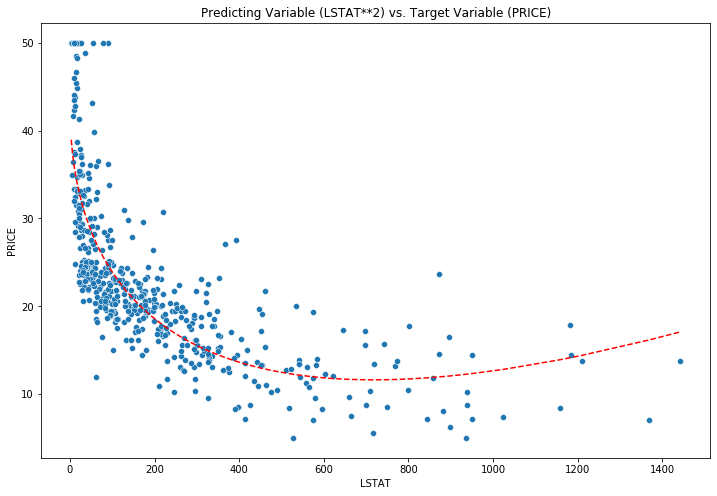

In [14]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=boston_data.LSTAT**2,
    y=boston_data.PRICE
)

sns.lineplot(
    x=boston_data.LSTAT**2,
    y=m02.fittedvalues,
    color='r',
    linestyle='--'
)

# plt.plot(boston_data.LSTAT**2, m02.fittedvalues, color='r', linestyle='--')
plt.title('Predicting Variable (LSTAT**2) vs. Target Variable (PRICE)')
plt.xlabel('LSTAT')
plt.ylabel('PRICE')

Text(0, 0.5, 'Residuals')

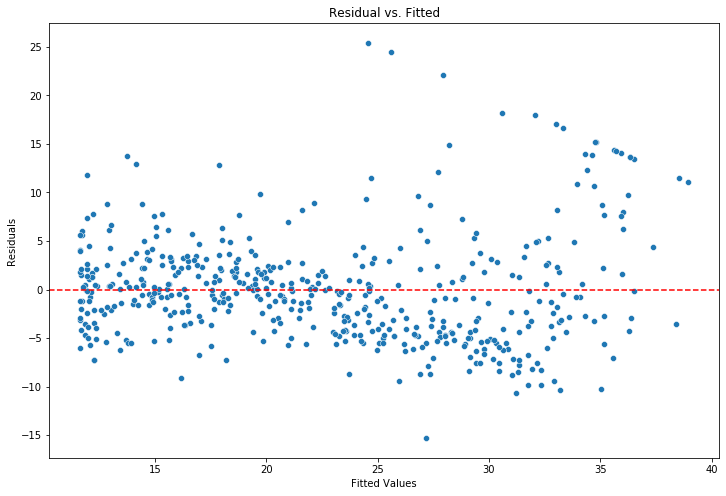

In [15]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=m02.fittedvalues,
    y=(boston_y - m02.fittedvalues)
)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual vs. Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

In [16]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=5)
LSTAT_poly = polynomial_features.fit_transform(boston_data.LSTAT.values.reshape(-1, 1))
LSTAT_poly_np = np.array(LSTAT_poly).reshape(6, -1)

for i in range(2, 6):
	boston_data['LSTAT_{}'.format(i)] = LSTAT_poly_np[i]

m03_poly = smf.ols(formula='PRICE ~ LSTAT + LSTAT_2 + LSTAT_3 + LSTAT_4 + LSTAT_5', data=boston_data).fit()
print(m03_poly.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     120.6
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           1.54e-83
Time:                        13:27:05   Log-Likelihood:                -1640.1
No. Observations:                 506   AIC:                             3292.
Df Residuals:                     500   BIC:                             3318.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.4292      0.573     60.113      0.0

In [17]:
df_carseats = pd.read_csv('https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Carseats.csv')
df_carseats.drop('Unnamed: 0', axis=1, inplace=True)

In [18]:
df_carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [19]:
carseats_cols = ' + '.join(df_carseats.columns[1:])

In [20]:
carseats_sm = smf.ols(formula='Sales ~ {} + Income:Advertising + Price:Age'.format(carseats_cols), data=df_carseats).fit()
print(carseats_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Fri, 22 Apr 2022   Prob (F-statistic):          6.14e-166
Time:                        13:27:05   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.5756    